In [349]:
import os 
import pandas as pd 
import numpy as np
from PIL import Image
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

import keras 
from keras.applications.vgg16 import VGG16


### train_test_split the training dataset provided by kaggle

In [34]:
data_dir = '/Users/yueying.teng/Documents/dog_breeds'
label_csv_path = os.path.join(data_dir, './data/labels.csv')

df = pd.read_csv(label_csv_path)

print(df.shape)

df.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [35]:

# split each id into a group in a list
gb = df.groupby('id')

grouped_list = [gb.get_group(x) for x in gb.groups]

# split ids into train and test groups 
train_index = np.random.choice(len(grouped_list), size = int(df.shape[0] * 0.8), replace = False)
# use np.setdiff1d for the difference of two arrays to get test index
test_index = np.setdiff1d(list(range(df.shape[0])), train_index)

print(len(train_index), len(test_index))                          
                          

8177 2045


In [79]:
grouped_list[0]

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull


In [36]:
# group dataset using the index from before 
train = pd.concat([grouped_list[i]for i in train_index])
test = pd.concat([grouped_list[i] for i in test_index])

# save the splitted the train test csv 
train.to_csv('./data/train_labels.csv', index=None)
test.to_csv('./data/test_labels.csv', index=None)


### create subfolders for each breed

In [38]:
# train and test labels and ids
train = pd.read_csv('./data/train_labels.csv')
test = pd.read_csv('./data/test_labels.csv')     
                    
img_dir = os.path.join(data_dir, 'image')


In [39]:

# create subdfolders of breeds name and put correspounding images in 
path = 'train'

for i, (fname, breed) in train.iterrows():
    breed_img_dir = '%s/%s' % (path, breed)
    if not os.path.exists(breed_img_dir):
        os.makedirs(breed_img_dir)
        
    os.symlink('%s/%s.jpg' % (img_dir, fname), '%s/%s.jpg' % (breed_img_dir, fname))
    
    

In [40]:
# same for testing data 

# create subdfolders of breeds name and put correspounding images in 
path = 'test'

for i, (fname, breed) in test.iterrows():
    breed_img_dir = '%s/%s' % (path, breed)
    if not os.path.exists(breed_img_dir):
        os.makedirs(breed_img_dir)
        
    os.symlink('%s/%s.jpg' % (img_dir, fname), '%s/%s.jpg' % (breed_img_dir, fname))
    
    

### EDA

In [50]:
# check if all the calsses in training set are balanced 

# training, testing data directory 
train_img_dir = os.path.join(data_dir, 'train')
test_img_dir = os.path.join(data_dir, 'test')
train_folders = os.listdir(train_img_dir)

num_sample = []
for i in train_folders:
    if i not in '.DS_Store':
        subfolder = os.path.join(data_dir,'train', i)
        files = os.listdir(subfolder)
        num_sample.append(len(files))


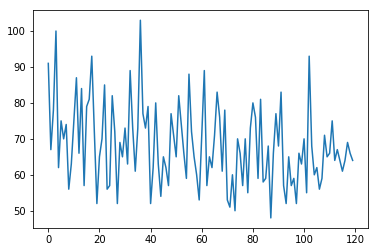

In [55]:
plt.plot(num_sample)

In [65]:
# image size inspection 

img_size = {}
for i in folders:
    if i not in '.DS_Store':
        subfolder = os.path.join(data_dir,'train', i)
        files = os.listdir(subfolder)
        for j in files:
            if j not in '.DS_Store':
                img = Image.open(os.path.join(data_dir,'train', i, j))
                width, height = img.size 
                img_size.setdefault(j, []).append((width, height))
    

In [71]:
keys = list(img_size.keys())

x = []
y = []
for i in range(len(keys)):
    x.append(img_size[keys[i]][0][0])
    y.append(img_size[keys[i]][0][1])

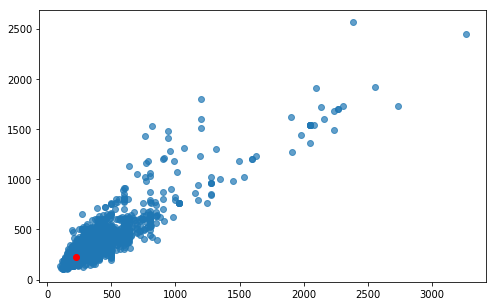

In [298]:
plt.figure(figsize = (8, 5))
plt.scatter(x, y, alpha = 0.7)
plt.scatter(224, 224, color = 'red')


In [76]:
print (min(x), min(y))

97 102


### image preprocessing for VGG transfer leanring 

1. decode the images from jpg to array
2. resize the images to (224, 224), while keeping the original aspect ratio
3. subtract the color channel mean used in the original VGG training 

the above steps have to be done for both training and testing images 

In [77]:
from keras.preprocessing import image


Using TensorFlow backend.


In [88]:
def list_dir(directory):
    """
    get all images and labels in directory/label/*.jpg
    """
    
    labels = os.listdir(directory)
    # sort the labels so that training and testing get them in the same order
    labels.sort()
    
    files_and_labels = []
    for label in labels:
        if label not in '.DS_Store':
            for f in os.listdir(os.path.join(directory, label)):
                files_and_labels.append((os.path.join(directory, label, f), label))

    filenames, labels = zip(*files_and_labels)
    filenames = list(filenames)
    labels = list(labels)
    unique_labels = list(set(labels))
    
    label_to_int = {}
    for i, label in enumerate(unique_labels):
        label_to_int[label] = i
    
    labels = [label_to_int[l] for l in labels]
    
    return filenames, labels


In [343]:
def img_process(filenames):
    """
    image preprocessing for VGG transfer learning
    1. resize image so that the short side has minimal length, while keeping the aspect ratio;
    fill the boarder with zero paddings to create image of size (224, 224, 3)
    2. convert jpg to array
    3. subtract the mean used in the original VGG training 
    """
    
    longest = 224 # for resizing
    
    img_list = [] # to store processed images
    
    for i in range(len(filenames)):

        img = image.load_img(filenames[i])
        
        # resize and padding 
        # find the proportion from the longer side to make sure the longest side is 224
        if img.size[0] >=img.size[1]:
            percent = (longest/float(img.size[0]))
            hsize = int((float(img.size[1])*float(percent)))
            re_img = img.resize((longest,hsize), PIL.Image.ANTIALIAS)
        else:
            percent = (longest/float(img.size[1]))
            hsize = int((float(img.size[0])*float(percent)))
            re_img = img.resize((hsize, longest), PIL.Image.ANTIALIAS)
        
        # add zero padding 
        old_size = re_img.size

        new_size = (224, 224)
        new_img = Image.new('RGB', new_size, (255, 255, 255))
        new_img.paste(re_img, ((new_size[0] - old_size[0])//2, (new_size[1] - old_size[1])//2))
        
        # covert to array
        img_arr = image.img_to_array(new_img)
 
        # mean subtraction - R: 123.68, G: 116.78, B: 103.94 
        img_arr[:, :, 0] -= 123.68
        img_arr[:, :, 1] -= 116.78
        img_arr[:, :, 2] -= 103.94 
        
        img_list.append(img_arr)
         
    # convert the processed list of images to array and return as function output
    img_output_arr = np.array(img_list)
    
    return img_output_arr


In [351]:
# pre process both train and test images

file_train, label_train = list_dir('/Users/yueying.teng/Documents/dog_breeds/train')
x_train = img_process(file_train)

file_test, label_test = list_dir('/Users/yueying.teng/Documents/dog_breeds/test')
x_test = img_process(file_test)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


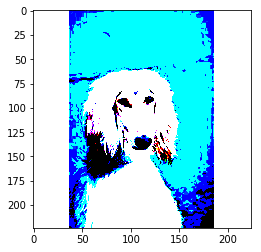

In [354]:
# show one image after pre processing
plt.imshow(x_train[150])

### bottleneck feature extraction

In [350]:
# load pretrained VGG16

model = VGG16(weights = 'imagenet', include_top = False)
model.summary()

58892288/58889256 [==============================] - 43s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_poo

In [ ]:
%%time

# extract bottleneck feature

feature_train = model.predict(x_train)
feature_test = model.predict(x_test)

np.save('bnf_train.npy', feature_train)
np.save('bnf_test.npy', feature_test)
